# Overview

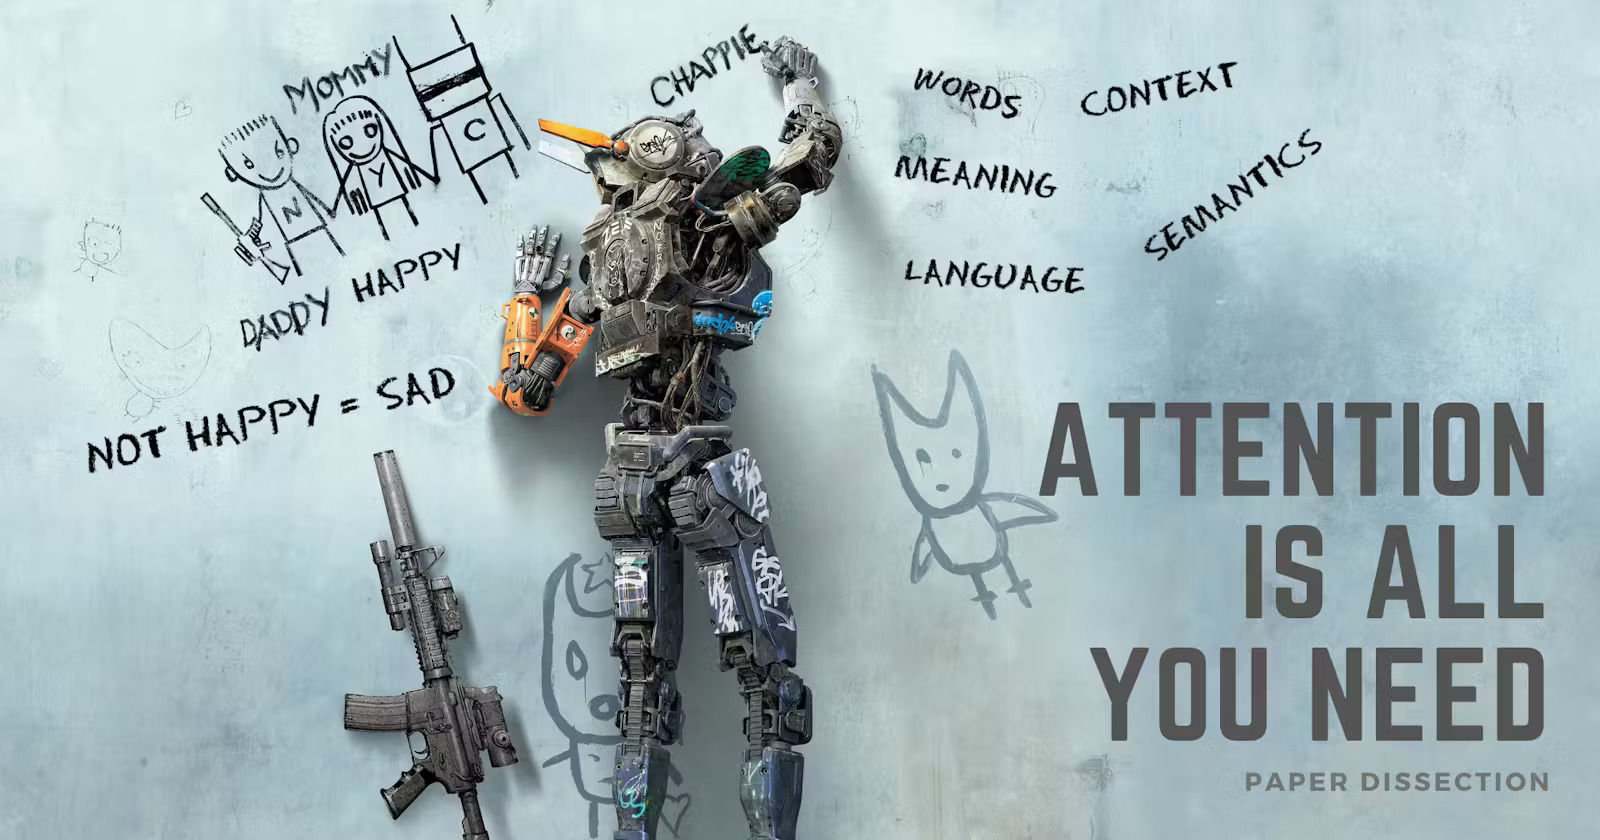

It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

In this Notebook I will start with the very Basics of NLP and Build all the way to latest deep learning architectures, It will cover the Following:

- Simple BagOfWords Machine Learning Model (Benchmark)
- RNN
- LSTM/GRU
- BI-Directional LSTM
- Transformers - Attention is all you need

# Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Submission File
For each ID in the test set, you must predict a probability for the toxic variable. The file should contain a header and have the following format:

> id,  toxic
>
> 0,  0.5
>
> 1,  1

In [1]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
# !ls
# !pwd

In [2]:
# !cp /content/glove.6B.300d.txt /content/drive/MyDrive/

In [3]:
# !pip install --upgrade pip
# !pip install --upgrade nltk
# !pip install --upgrade tensorflow tensorflow-gpu
# !pip install --upgrade spacy

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import joblib
import re
import gc
from tqdm import tqdm
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D, LSTM, GRU, SimpleRNN, Dense, Activation, Dropout, Embedding, BatchNormalization, TextVectorization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
import spacy # spacy after tensorflow to avoid conflicting GPUs
import warnings
warnings.filterwarnings('ignore')

np.random.seed(571)

print(tf.__version__)

2.15.0


In [4]:
# TPU detection and initialization (Kaggle/Colab)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print('TPU not found. Error:', e)
    tpu = None
    strategy = tf.distribute.get_strategy()
except Exception as e:
    print("Error during TPU initialization:", e)
    strategy = tf.distribute.get_strategy()

print("REPLICAS:", strategy.num_replicas_in_sync)

Running on TPU
REPLICAS: 8


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_all = pd.read_csv('/content/drive/MyDrive/toxic-comment-train.csv', engine="python")
df_all

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


**See the num.of presented Samples in DataFrame**

In [8]:
(df_all.drop(['id','comment_text'], axis=1)).apply(lambda a: a.value_counts())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,202165,221587,211409,222860,212245,221432
1,21384,1962,12140,689,11304,2117


**Merge Columns in One Column 'is_offensive' expressing to any form of offensive sentence (toxic, severe_toxic, obscene, threat, insult, identity_hate) -IF NEEDED-**

I will just use the toxic column to the competition Submittion

In [9]:
df_all['is_offensive'] = df_all['toxic'] # df_all['toxic'] | df_all['severe_toxic'] | df_all['obscene'] | df_all['threat'] | df_all['insult'] | df_all['identity_hate'] | 0
(df_all.drop(['id','comment_text'], axis=1)).apply(lambda a: a.value_counts())

,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_offensive
0,202165,221587,211409,222860,212245,221432,202165
1,21384,1962,12140,689,11304,2117,21384


**Apply Pre-Process on text to improve the models Perforamance**

**[Remove Punctuation, Special Characters & Stop Words - Lowercasing - Tokenization - Lemmatization - Handle Contraction]**

In [10]:
# Disable GPU usage for SpaCy (GPUs Conflict Error in TensorFlow)
# spacy.require_cpu()

# Load the SpaCy small model to tokenize the texts
nlp = spacy.load("en_core_web_sm", enable=["tokenizer", "lemmatizer"])
contractions_dict = {"'m": "am", "'s": "is", "'re": "are", "n't": "not","'ll": "will",
                     "'d": "would", "'ve": "have", "ca": "can","sha": "shall", "wo":"will"}

# Initialize tqdm for pandas
tqdm.pandas()

def preprocess_text(text):
    """
    Optimized text preprocessing using spaCy.
    """
    # Pre-Process the text
    text = re.sub(r'[^\w\s\']', '', text)
    doc = nlp(text.lower())
    tokens = [contractions_dict.get(token.text, token.lemma_) for token in doc if not token.is_stop]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply the function to the DataFrame
df_all['comment_text'] = df_all['comment_text'].progress_apply(preprocess_text)

# Release spaCy model from memory
del nlp
gc.collect()

# Display The tail of the data
df_all.tail()

100%|██████████| 223549/223549 [01:58<00:00, 1892.11it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_offensive
223544,fff8f64043129fa2,jerome got m surprised looked example nomine p...,0,0,0,0,0,0,0
223545,fff9d70fe0722906,lucky bastard \n httpwikimediafoundationorgwi...,0,0,0,0,0,0,0
223546,fffa8a11c4378854,shame \n\n want speak gays romanians,0,0,0,0,0,0,0
223547,fffac2a094c8e0e2,mel gibson nazi bitch makes shitty movies butt...,1,0,1,0,1,0,1
223548,fffb5451268fb5ba,\n\n unicorn lair discovery \n\n supposed...,0,0,0,0,0,0,0


**Split DataFrame to train & test sets to compute the accuracy of the models**

In [11]:
num = 200_000
df = df_all.iloc[:num, :].dropna()
test = df_all.iloc[num:, :].dropna()

print("The Shape of Train Data: ", df.shape)
print("The Shape of Test Data: ", test.shape)

The Shape of Train Data:  (200000, 9)
The Shape of Test Data:  (23549, 9)


**UnderSampling for the class 0 to the length of class 1 to solve imbalanced data and decreased the size of the data**

**Trying to get smaller subset of data and overcome the imbalanced data problem [IF Needed]**

In [12]:
# the count of rows in each class of the is_offensive 1/0
len_class = np.max(df.is_offensive.value_counts())

# separate according to `label`
df_class_0 = df[df['is_offensive'] == 0]
df_class_1 = df[df['is_offensive'] == 1]

# sample only from class 0 quantity of rows of class 1
df_class_0 = df_class_0.sample(len_class, replace=True)
df_class_1 = df_class_1.sample(len_class, replace=True)

df = pd.concat([df_class_0, df_class_1], ignore_index = True, axis=0).sample(frac = 1).reset_index()
(df['is_offensive'].value_counts())

is_offensive
0    180869
1    180869
Name: count, dtype: int64

# Bag of Words - Traditional ML

**This is the matrix will used in the competition**

In [13]:
def AUC_accuracy(target, predictions):
    '''
    Compute the Area Under Curve (AUC) Score to get the accuracy of the model

    Paramas:
        target -> list of real numbers
        predictions -> list of predictions numbers

    return auc accuracy (float)
    '''

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [14]:
# get the comment text in X and is_offensive in Y
X = df['comment_text']
y = df['is_offensive']

# spliting the train dataset to sub-train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y.values, random_state=42)
X_test, y_test = test['comment_text'], test['is_offensive']

print("The Shape of Train Data: ", X_train.shape)
print("The Shape of Validation Data: ", X_val.shape)
print("The Shape of Test Data: ", X_test.shape)

The Shape of Train Data:  (325564,)
The Shape of Validation Data:  (36174,)
The Shape of Test Data:  (23549,)


In [15]:
# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print("The Shape of Train Data After Victorizer: ", X_train_vec.shape)
print("The Shape of Validation Data After Victorizer: ", X_val_vec.shape)

The Shape of Train Data After Victorizer:  (325564, 221577)
The Shape of Validation Data After Victorizer:  (36174, 221577)


In [16]:
# Train simple ML model for text classification task
LRmodel  =  LogisticRegression(max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train_vec, y_train)

# Predict on validation data
y_predLR = LRmodel.predict(X_val_vec)

# Evaluate the model
print("Logistic Regression on Validation Data")
print(classification_report(y_val, y_predLR))

Logistic Regression on Validation Data
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     18087
           1       0.96      0.97      0.96     18087

    accuracy                           0.96     36174
   macro avg       0.96      0.96      0.96     36174
weighted avg       0.96      0.96      0.96     36174



**Let's try to get the accuracy on test dataset**

In [17]:
test_vec = vectorizer.transform(X_test)
y_preds = LRmodel.predict(test_vec)

# Evaluate the model
print("Logistic Regression on Test Data")
print(classification_report(y_test, y_preds))

Logistic Regression on Test Data
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     21296
           1       0.46      0.89      0.61      2253

    accuracy                           0.89     23549
   macro avg       0.72      0.89      0.77     23549
weighted avg       0.94      0.89      0.90     23549



In [18]:
# Note we need the decision_function to predict confidence scores for samples
# (the distance between point and hyperplane)
# for getting area under curve (auc) as an accuracy matrix
y_preds_prob = LRmodel.decision_function(test_vec)
lr_score = AUC_accuracy(y_test, y_preds_prob)
lr_score

0.9568343927772404

# Deep Learning

**Get The longest sequance on the Train data**

In [19]:
df['comment_text'].apply(lambda comment: len(comment.split())).max()

1250

**Tokenize & Padding Sequance of the training data from tensorflow pre-processing**

In [20]:
# Define embedding dimensions and maximum sequence length
# embedding_dim: the number of features that represent the word
embedding_dim = 300
max_len = 1300

# using keras tokenizer here
token = text.Tokenizer(oov_token="<OOV>")

# tokenize the texts to sort desc
# the highest counts for the word
# in the corpus and get the indeces
token.fit_on_texts(X_train.to_list() + X_val.to_list())
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

# padding the sequences to 2000 indices [constant shape]
# for fitting input layer of the Deep Learning model
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = sequence.pad_sequences(X_val_seq, maxlen=max_len, padding='post')

word2idx = token.word_index
vocab_size = len(token.word_index) + 1

print("The distinct number of words in corpus", vocab_size)

The distinct number of words in corpus 232971


**Tokenize & Padding Sequance of the TEST data**

In [21]:
X_test_seq = token.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len, padding='post')
print("tokenize the test dataset ..")
print("The Test Shape: ", X_test_pad.shape)

tokenize the test dataset ..
The Test Shape:  (23549, 1300)


**Let's Make Simple Neural Nets for BagOfWords [Count matrix] model to get the best accuracy for Traditional ML**

In [22]:
with strategy.scope():
    # Create the model
    model = Sequential()

    # Add layers
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        mask_zero=True))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # For binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_val_pad, y_val),
                    epochs=10,
                    batch_size=64*strategy.num_replicas_in_sync,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)])


# Summary of the model
model.summary()

Epoch 1/10
636/636 [==============================] - 57s 73ms/step - loss: 0.1184 - accuracy: 0.9556 - val_loss: 0.1545 - val_accuracy: 0.9414
Epoch 2/10
636/636 [==============================] - 35s 55ms/step - loss: 0.0306 - accuracy: 0.9907 - val_loss: 0.0705 - val_accuracy: 0.9784
Epoch 3/10
636/636 [==============================] - 35s 55ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0696 - val_accuracy: 0.9818
Epoch 4/10
636/636 [==============================] - 35s 55ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0330 - val_accuracy: 0.9911
Epoch 5/10
636/636 [==============================] - 35s 55ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0658 - val_accuracy: 0.9789
Epoch 6/10
636/636 [==============================] - 35s 55ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0419 - val_accuracy: 0.9897
Epoch 7/10
636/636 [==============================] - 35s 55ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0273 - val_accuracy:

**Getting the accuracy on Test Dataset**

In [23]:
preds_prob = model.predict(X_test_pad)
print("Simple Neural Nets BagOfWords Result\n")
print(classification_report(y_test, np.round(preds_prob).astype(int))) # convert probabilities to 1 or 0 according the threshold 0.5

736/736 [==============================] - 9s 11ms/step
Simple Neural Nets BagOfWords Result

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     21296
           1       0.52      0.81      0.63      2253

    accuracy                           0.91     23549
   macro avg       0.75      0.87      0.79     23549
weighted avg       0.93      0.91      0.92     23549



In [24]:
BagOfWords_score = AUC_accuracy(y_test, preds_prob)
BagOfWords_score

0.9423134856004667

**It is Limited, The Traditional Machine Learning and Simple Neural Nets is not the solution**

## GloVe (Word Embeddings)

In [25]:
def word2GloVeEmbed(corpus, filepath= r'/content/drive/MyDrive/glove.6B.300d.txt'):
    """
    Load GloVe embeddings for specific words from a file

    Args:
        corpus (set): A set of words to extract embeddings for
        filepath (str): Path to the GloVe embeddings file

    Returns:
        dict: A dictionary mapping words to their GloVe embeddings
    """
    word2vec = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in tqdm(file):
            values = line.rstrip().split(' ')
            word = ' '.join(values[:-300])
            if word in corpus: # if the word in the corpus
                vector = np.asarray(values[-300:], dtype='float32') # 300 is the number of the length of the embeddings
                word2vec[word] = vector
            if len(word2vec) == len(corpus):  # Stop early if all words are found
                break
    return word2vec

**We have already tokenized and paded our text to extract the words from train dateset**

In [26]:
# convert all the words of the train-data into GloVe Embedding Vectors
word2vec = word2GloVeEmbed(word2idx.keys())
print(f'The shape of the word2vec: {len(word2vec)}')

400000it [00:11, 33516.12it/s]

The shape of the word2vec: 89496


In [27]:
# # Save the subset to a text file
# with open("dataset_glove.txt", 'w', encoding='utf-8') as output_file:
#     for word, vector in word2vec.items():
#         vector_str = ' '.join(map(str, vector))
#         output_file.write(f"{word} {vector_str}\n")

In [28]:
print("The vector of the word 'The'", word2vec['the'])

The vector of the word 'The' [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-02 -1.1129e-01
 -4.2085e-01  1.3992e-

**Extract Vectors of the unique words in dataset**

In [29]:
# create an embeddings matrix for the words we have in the dataset
embed_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tqdm(word2idx.items()):
    vector = word2vec.get(word, None)
    if vector is not None:
        embed_matrix[i] = vector

print(f'\nThe shape of embeddings matrix: {embed_matrix.shape}')

100%|██████████| 232970/232970 [00:00<00:00, 449320.63it/s]


The shape of embeddings matrix: (232971, 300)


# RNN model

**Recurrent Neural Network(RNN) is a type of Neural Network where the output from the previous step is fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other. Still, in cases when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer. The main and most important feature of RNN is its Hidden state, which remembers some information about a sequence. The state is also referred to as Memory State since it remembers the previous input to the network. It uses the same parameters for each input as it performs the same task on all the inputs or hidden layers to produce the output. This reduces the complexity of parameters, unlike other neural networks.**

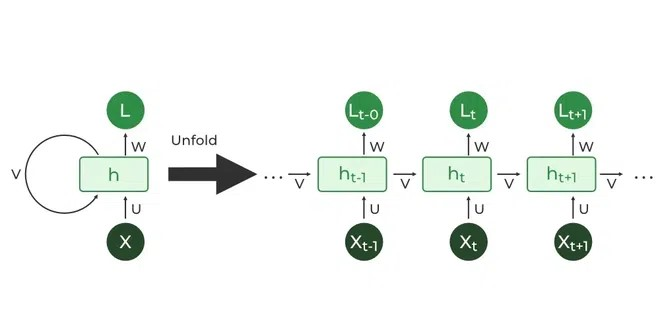

In [31]:
# A SimpleRNN with GloVe embeddings
with strategy.scope():
    # Create the model
    model = Sequential()

    # Add layers
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        mask_zero=True,
                        weights=[embed_matrix],
                        trainable=False
                       ))

    # model.add(SimpleRNN(128, return_sequences=True))
    # model.add(Dropout(0.2))

    model.add(SimpleRNN(128))
    model.add(Dropout(0.2))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train,
          validation_data=(X_val_pad, y_val),
          epochs=10,
          batch_size=64*strategy.num_replicas_in_sync,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)])

model.summary()

Epoch 1/10
636/636 [==============================] - 52s 70ms/step - loss: 0.2933 - accuracy: 0.8784 - val_loss: 0.2384 - val_accuracy: 0.9044
Epoch 2/10
636/636 [==============================] - 36s 57ms/step - loss: 0.2411 - accuracy: 0.9030 - val_loss: 0.2484 - val_accuracy: 0.9004
Epoch 3/10
636/636 [==============================] - 36s 57ms/step - loss: 0.2138 - accuracy: 0.9167 - val_loss: 0.2086 - val_accuracy: 0.9234
Epoch 4/10
636/636 [==============================] - 36s 57ms/step - loss: 0.2841 - accuracy: 0.8817 - val_loss: 0.2580 - val_accuracy: 0.8954
Epoch 5/10
636/636 [==============================] - 36s 57ms/step - loss: 0.2399 - accuracy: 0.9040 - val_loss: 0.1863 - val_accuracy: 0.9298
Epoch 6/10
636/636 [==============================] - 37s 57ms/step - loss: 0.1919 - accuracy: 0.9265 - val_loss: 0.1563 - val_accuracy: 0.9452
Epoch 7/10
636/636 [==============================] - 36s 57ms/step - loss: 0.1705 - accuracy: 0.9356 - val_loss: 0.1261 - val_accuracy:

In [32]:
model.evaluate(X_test_pad, y_test)[1]

736/736 [==============================] - 14s 17ms/step - loss: 0.4185 - accuracy: 0.8564


0.8563845753669739

In [33]:
# get predictions
SimpleRNN_preds = np.round(model.predict(X_test_pad)).astype(int)
print("Simple RNN predictions \n", classification_report(y_test, SimpleRNN_preds))

736/736 [==============================] - 14s 17ms/step
Simple RNN predictions 
               precision    recall  f1-score   support

           0       0.98      0.85      0.91     21296
           1       0.39      0.88      0.54      2253

    accuracy                           0.86     23549
   macro avg       0.69      0.86      0.73     23549
weighted avg       0.93      0.86      0.88     23549



In [34]:
rnn_score = AUC_accuracy(y_test, SimpleRNN_preds)
rnn_score

0.86483160402542

### Advantages and Disadvantages of Recurrent Neural Network
## Advantages
- An RNN remembers each and every piece of information through time. It is useful in time series prediction only because of the feature to remember previous inputs as well. This is called Long Short Term Memory.
- Recurrent neural networks are even used with convolutional layers to extend the effective pixel neighborhood.

## Disadvantages
- Gradient vanishing and exploding problems.
- Training an RNN is a very difficult task.
- It cannot process very long sequences if using tanh or relu as an activation function.

**For these problems, the LSTM came.**

# LSTM

**LSTM networks are an extension of recurrent neural networks (RNNs) mainly introduced to handle situations where RNNs fail**

- It fails to store information for a longer period of time. At times, a reference to certain information stored quite a long time ago is required to predict the current output. But RNNs are absolutely incapable of handling such “long-term dependencies”.
- There is no finer control over which part of the context needs to be carried forward and how much of the past needs to be ‘forgotten’.
- Other issues with RNNs are exploding and vanishing gradients (explained later) which occur during the training process of a network through backtracking.

**The basic difference between the architectures of RNNs and LSTMs is that the hidden layer of LSTM is a gated unit or gated cell. It consists of four layers that interact with one another in a way to produce the output of that cell along with the cell state. These two things are then passed onto the next hidden layer. Unlike RNNs which have got only a single neural net layer of tanh, LSTMs comprise three logistic sigmoid gates and one tanh layer. Gates have been introduced in order to limit the information that is passed through the cell. They determine which part of the information will be needed by the next cell and which part is to be discarded. The output is usually in the range of 0-1 where ‘0’ means ‘reject all’ and ‘1’ means ‘include all’.**



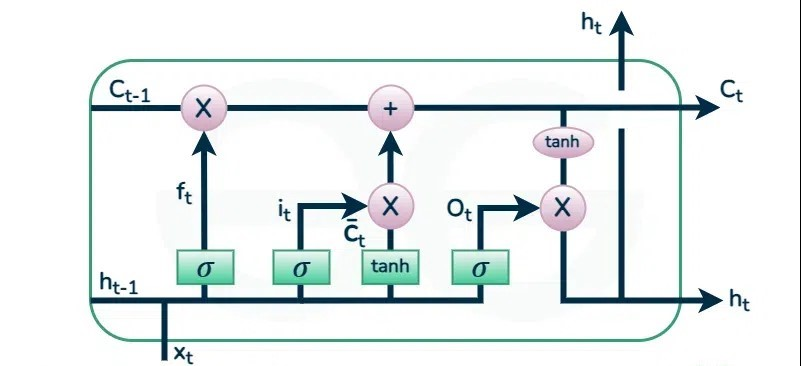

In [35]:
# A LSTM with GloVe embeddings
with strategy.scope():
    # Create the model
    model = Sequential()

    # Add layers
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        mask_zero=True,
                        weights=[embed_matrix],
                        trainable=False
                       ))

    # model.add(LSTM(128, return_sequences=True))
    # model.add(Dropout(0.2))

    model.add(LSTM(128))
    model.add(Dropout(0.2))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train,
          validation_data=(X_val_pad, y_val),
          epochs=10,
          batch_size=64*strategy.num_replicas_in_sync,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)])

model.summary()

Epoch 1/10
636/636 [==============================] - 96s 135ms/step - loss: 0.2438 - accuracy: 0.8990 - val_loss: 0.1857 - val_accuracy: 0.9262
Epoch 2/10
636/636 [==============================] - 74s 116ms/step - loss: 0.1764 - accuracy: 0.9303 - val_loss: 0.1353 - val_accuracy: 0.9495
Epoch 3/10
636/636 [==============================] - 74s 116ms/step - loss: 0.1262 - accuracy: 0.9538 - val_loss: 0.1098 - val_accuracy: 0.9607
Epoch 4/10
636/636 [==============================] - 74s 116ms/step - loss: 0.0967 - accuracy: 0.9662 - val_loss: 0.0833 - val_accuracy: 0.9726
Epoch 5/10
636/636 [==============================] - 74s 116ms/step - loss: 0.0839 - accuracy: 0.9718 - val_loss: 0.0804 - val_accuracy: 0.9730
Epoch 6/10
636/636 [==============================] - 74s 116ms/step - loss: 0.0639 - accuracy: 0.9793 - val_loss: 0.0667 - val_accuracy: 0.9780
Epoch 7/10
636/636 [==============================] - 74s 116ms/step - loss: 0.0516 - accuracy: 0.9835 - val_loss: 0.0705 - val_ac

In [36]:
model.evaluate(X_test_pad, y_test)[1]

736/736 [==============================] - 23s 29ms/step - loss: 0.4668 - accuracy: 0.8916


0.8915877342224121

In [37]:
# get predictions
LSTM_preds = np.round(model.predict(X_test_pad)).astype(int)
print("Simple LSTM predictions \n", classification_report(y_test, LSTM_preds))

736/736 [==============================] - 23s 28ms/step
Simple LSTM predictions 
               precision    recall  f1-score   support

           0       0.98      0.89      0.94     21296
           1       0.46      0.87      0.60      2253

    accuracy                           0.89     23549
   macro avg       0.72      0.88      0.77     23549
weighted avg       0.93      0.89      0.91     23549



In [38]:
LSTM_score = AUC_accuracy(y_test, LSTM_preds)
LSTM_score

0.8803263984276077

### Drawbacks of Using LSTM Networks
##### As it is said, everything in this world comes with its own advantages and disadvantages, LSTMs too, have a few drawbacks which are discussed below:

- LSTMs became popular because they could solve the problem of vanishing gradients. But it turns out, they fail to remove it completely. The problem lies in the fact that the data still has to move from cell to cell for its evaluation. Moreover, the cell has become quite complex now with additional features (such as forget gates) being brought into the picture.
- They require a lot of resources and time to get trained and become ready for real-world applications. In technical terms, they need high memory bandwidth because of the linear layers present in each cell which the system usually fails to provide. Thus, hardware-wise, LSTMs become quite inefficient.
- With the rise of data mining, developers are looking for a model that can remember past information for a longer time than LSTMs. The source of inspiration for such kind of model is the human habit of dividing a given piece of information into small parts for easy remembrance.
- LSTMs get affected by different random weight initialization and hence behave quite similarly to that of a feed-forward neural net. They prefer small-weight initialization instead.
- LSTMs are prone to overfitting and it is difficult to apply the dropout algorithm to curb this issue. Dropout is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network.


# GRU

#### GRU v/s LSTM
**In spite of being quite similar to LSTMs, GRUs have never been so popular. But what are GRUs? GRU stands for Gated Recurrent Units. As the name suggests, these recurrent units, proposed by Cho, are also provided with a gated mechanism to effectively and adaptively capture dependencies of different time scales. They have an update gate and a reset gate. The former is responsible for selecting what piece of knowledge is to be carried forward, whereas the latter lies in between two successive recurrent units and decides how much information needs to be forgotten**

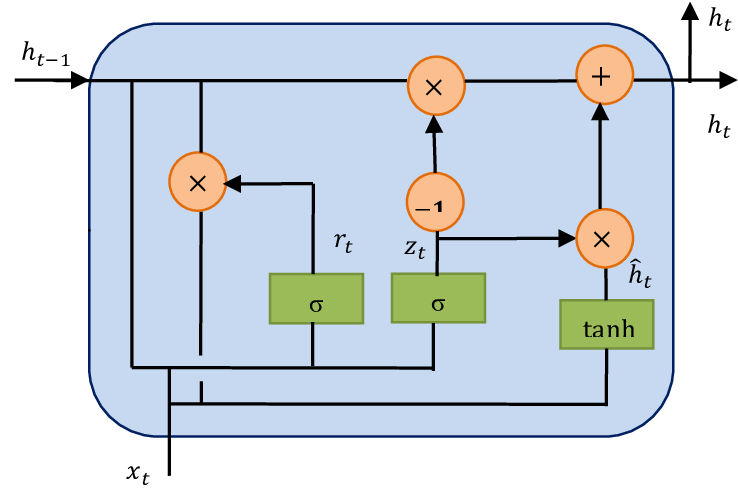

In [39]:
# A GRU with GloVe embeddings
with strategy.scope():
    # Create the model
    model = Sequential()

    # Add layers
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        mask_zero=True,
                        weights=[embed_matrix],
                        trainable=False
                       ))

    # model.add(GRU(128, return_sequences=True))
    # model.add(Dropout(0.2))

    model.add(GRU(128))
    model.add(Dropout(0.2))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train,
          validation_data=(X_val_pad, y_val),
          epochs=10,
          batch_size=64*strategy.num_replicas_in_sync,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)])

model.summary()

Epoch 1/10
636/636 [==============================] - 88s 122ms/step - loss: 0.2479 - accuracy: 0.8970 - val_loss: 0.1801 - val_accuracy: 0.9275
Epoch 2/10
636/636 [==============================] - 67s 105ms/step - loss: 0.1651 - accuracy: 0.9356 - val_loss: 0.1327 - val_accuracy: 0.9509
Epoch 3/10
636/636 [==============================] - 67s 105ms/step - loss: 0.1210 - accuracy: 0.9559 - val_loss: 0.1095 - val_accuracy: 0.9638
Epoch 4/10
636/636 [==============================] - 67s 105ms/step - loss: 0.0895 - accuracy: 0.9695 - val_loss: 0.0834 - val_accuracy: 0.9722
Epoch 5/10
636/636 [==============================] - 67s 105ms/step - loss: 0.0677 - accuracy: 0.9776 - val_loss: 0.0660 - val_accuracy: 0.9793
Epoch 6/10
636/636 [==============================] - 67s 105ms/step - loss: 0.0549 - accuracy: 0.9824 - val_loss: 0.0599 - val_accuracy: 0.9814
Epoch 7/10
636/636 [==============================] - 67s 105ms/step - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0525 - val_ac

In [40]:
model.evaluate(X_test_pad, y_test)[1]

736/736 [==============================] - 23s 30ms/step - loss: 0.4517 - accuracy: 0.8991


0.8990615606307983

In [41]:
# get predictions
GRU_preds = np.round(model.predict(X_test_pad)).astype(int)
print("Simple GRU predictions \n", classification_report(y_test, GRU_preds))

736/736 [==============================] - 26s 30ms/step
Simple GRU predictions 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     21296
           1       0.48      0.84      0.62      2253

    accuracy                           0.90     23549
   macro avg       0.73      0.87      0.78     23549
weighted avg       0.93      0.90      0.91     23549



In [42]:
GRU_score = AUC_accuracy(y_test, GRU_preds)
GRU_score

0.8747346909188283

# Bidirectional LSTM

**The architecture of bidirectional LSTM comprises of two unidirectional LSTMs which process the sequence in both forward and backward directions. This architecture can be interpreted as having two separate LSTM networks, one gets the sequence of tokens as it is while the other gets in the reverse order. Both of these LSTM network returns a probability vector as output and the final output is the combination of both of these probabilities. It can be represented as:**

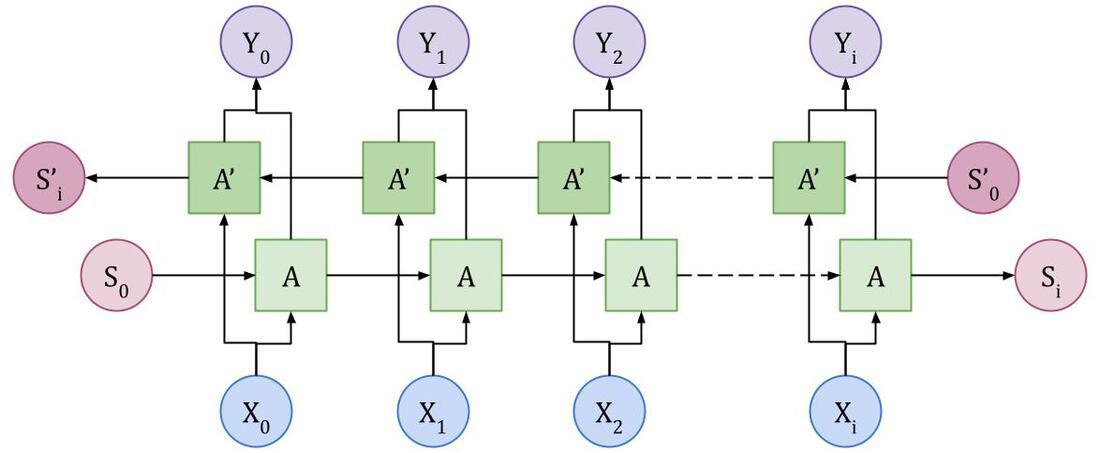

**To better understand this let us see an example. The first statement is “Server can you bring me this dish” and the second statement is “He crashed the server”. In both these statements, the word server has different meanings and this relationship depends on the following and preceding words in the statement. The bidirectional LSTM helps the machine to understand this relationship better than compared with unidirectional LSTM. This ability of BiLSTM makes it a suitable architecture for tasks like sentiment analysis, text classification, and machine translation.**

In [43]:
# A Bidirectional LSTM with GloVe embeddings
with strategy.scope():
    # Create the model
    model = Sequential()

    # Add layers
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=max_len,
                        mask_zero=True,
                        weights=[embed_matrix],
                        trainable=False
                       ))

    # model.add(Bidirectional(LSTM(100, return_sequences=True)))
    # model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.2))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train,
          validation_data=(X_val_pad, y_val),
          epochs=10,
          batch_size=64*strategy.num_replicas_in_sync,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)])

model.summary()

Epoch 1/10
636/636 [==============================] - 166s 239ms/step - loss: 0.2212 - accuracy: 0.9095 - val_loss: 0.1442 - val_accuracy: 0.9460
Epoch 2/10
636/636 [==============================] - 139s 218ms/step - loss: 0.1313 - accuracy: 0.9506 - val_loss: 0.0973 - val_accuracy: 0.9661
Epoch 3/10
636/636 [==============================] - 138s 218ms/step - loss: 0.0892 - accuracy: 0.9685 - val_loss: 0.0731 - val_accuracy: 0.9761
Epoch 4/10
636/636 [==============================] - 139s 218ms/step - loss: 0.0637 - accuracy: 0.9784 - val_loss: 0.0560 - val_accuracy: 0.9828
Epoch 5/10
636/636 [==============================] - 139s 218ms/step - loss: 0.0495 - accuracy: 0.9834 - val_loss: 0.0519 - val_accuracy: 0.9839
Epoch 6/10
636/636 [==============================] - 139s 218ms/step - loss: 0.0396 - accuracy: 0.9866 - val_loss: 0.0527 - val_accuracy: 0.9839
Epoch 7/10
636/636 [==============================] - 138s 218ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.0526 -

In [44]:
model.evaluate(X_test_pad, y_test)[1]

736/736 [==============================] - 35s 46ms/step - loss: 0.4576 - accuracy: 0.9107


0.9106543660163879

In [45]:
# get predictions
BiLSTM_preds = np.round(model.predict(X_test_pad)).astype(int)
print("Bidirectional LSTM predictions \n", classification_report(y_test, BiLSTM_preds))

736/736 [==============================] - 38s 47ms/step
Bidirectional LSTM predictions 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     21296
           1       0.52      0.84      0.64      2253

    accuracy                           0.91     23549
   macro avg       0.75      0.88      0.80     23549
weighted avg       0.94      0.91      0.92     23549



In [46]:
BiLSTM_score = AUC_accuracy(y_test, BiLSTM_preds)
BiLSTM_score

0.8773738383882846

##### Continued With BERT ..

# Attention is all you need (Transformers)

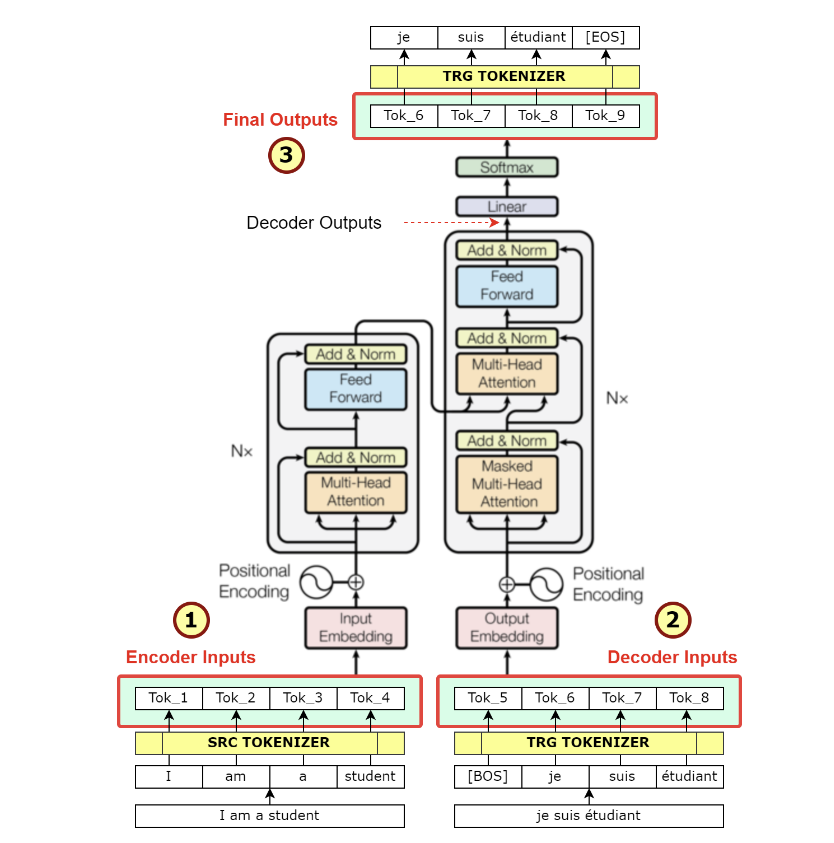

## BERT

### About BERT

BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

**NOW BERT IN TEXT CLASSIFICATION**

In [63]:
# Install necessary libraries
# !pip install --upgrade tensorflow, transformers

# Import libraries
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

In [64]:
# Initialize BERT Tokenizer & Model
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [65]:
# Define tokenization function
def tokenize_texts(tokenizer, texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

In [66]:
# BERT, Tokenize train and validation texts
train_encodings_bert = tokenize_texts(bert_tokenizer, X_train.tolist())
val_encodings_bert = tokenize_texts(bert_tokenizer, X_val.tolist())
test_encodings_bert = tokenize_texts(bert_tokenizer, X_test.tolist())

In [67]:
# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train.tolist())
val_labels = tf.convert_to_tensor(y_val.tolist())
test_labels = tf.convert_to_tensor(y_test.tolist())

In [68]:
# Create TensorFlow datasets
train_dataset_bert = tf.data.Dataset.from_tensor_slices((dict(train_encodings_bert), train_labels))
val_dataset_bert = tf.data.Dataset.from_tensor_slices((dict(val_encodings_bert), val_labels))
test_dataset_bert = tf.data.Dataset.from_tensor_slices((dict(test_encodings_bert), test_labels))

In [69]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    train_dataset_bert
    .shuffle(len(X_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    val_dataset_bert
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    test_dataset_bert
    .batch(BATCH_SIZE)
)

In [78]:
def build_bert_model(bert_base, max_len=512):
    """
    Build BERT Transformer model for text classification task.

    Args:
        bert_base (tf.keras.Model): BERT Transformer model.
        max_len (int): Maximum length of the input sequence.

    Returns:
        tf.keras.Model: BERT Transformer model.
    """
    # Define input layers
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # Wrap BERT model call in a Lambda layer
    def bert_model_call(inputs):
        input_ids, attention_mask = inputs
        return bert_base(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]  # Use the CLS token

    BERT_output = tf.keras.layers.Lambda(bert_model_call)([input_ids, attention_mask])

    # Add a dense layer with sigmoid activation
    output = tf.keras.layers.Dense(1, activation='sigmoid')(BERT_output)  # Assuming binary classification

    # Define the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

with strategy.scope():
    bert_base = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
    bert_model = build_bert_model(bert_base)

bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
The following Variables were used a Lambda layer's call (lambda_7), but
are

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 lambda_7 (Lambda)           (None, 768)                  0         ['input_ids[0][0]',           
                                                                     'attention_mask[0][0]']      
                                                                                            

In [79]:
# Train the model
history = bert_model.fit(train_dataset,
                         validation_data=valid_dataset,
                         epochs=3)

Epoch 1/3
10174/10174 [==============================] - 343s 32ms/step - loss: 0.4240 - accuracy: 0.8132 - val_loss: 0.3585 - val_accuracy: 0.8443
Epoch 2/3
10174/10174 [==============================] - 317s 31ms/step - loss: 0.3452 - accuracy: 0.8497 - val_loss: 0.3382 - val_accuracy: 0.8530
Epoch 3/3
10174/10174 [==============================] - 317s 31ms/step - loss: 0.3318 - accuracy: 0.8550 - val_loss: 0.3294 - val_accuracy: 0.8571


In [80]:
# Evaluate BERT model with layers
bert_eval = bert_model.evaluate(test_dataset)
print(f'BERT - Loss: {bert_eval[0]}, Accuracy: {bert_eval[1]}')

736/736 [==============================] - 22s 28ms/step - loss: 0.4019 - accuracy: 0.8212
BERT - Loss: 0.40188050270080566, Accuracy: 0.8212238550186157


In [81]:
# Predict the labels for the test dataset
predicted_labels = bert_model.predict(test_dataset)
predicted_labels = np.round(predicted_labels).astype(int)

# Generate classification report
report = classification_report(y_test.tolist(), predicted_labels)
print("Classification Report:\n", report)

736/736 [==============================] - 30s 28ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89     21296
           1       0.33      0.86      0.48      2253

    accuracy                           0.82     23549
   macro avg       0.66      0.84      0.69     23549
weighted avg       0.92      0.82      0.85     23549

